# Dynamic SSD with Focal Loss
Here I'll be trying out the RetinaNet implementation written by rohitgeo

# Imports  

In [1]:
from apex import amp
amp_handle = amp.init(enabled=True)
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from ssdoil import *
import ssdoil
from ssd import *
from utils import *

In [2]:
import importlib

In [3]:
import pandas as pd
from pathlib import Path

from fastai.vision.transform import get_transforms
from fastai.vision.data import ObjectItemList, imagenet_stats#, bb_pad_collate
from fastai import *
from fastai.vision import *

In [4]:
torch.cuda.current_device()

0

In [5]:
torch.cuda.device_count()

2

In [6]:
PATH = Path(r'./sim_data/')
JPEGS = 'JPEGImages'
# TEST_IMAGES_PATH = Path('../data/v_data/udacity_testarea_rgb/JPEGImages')
IMG_PATH = PATH/JPEGS


In [7]:
def remove_string_from_name(images):
    for i in range(len(images)):
        images[i] = images[i].split('/')[-1]
#         if '.png' in images[i]:
#             images[i] = images[i].replace('.png', '.jpg') 

In [8]:
def remove_unannotated_images(json_path):
    j = json.load(open(json_path))
    annotated_images = []
    for img in j['images']:
        img_id = img['id']
        matches = list(filter(lambda anno: anno['image_id'] == img_id, j['annotations']))
#         if img['id'] == 5087:
#             print(matches)
        if len(matches) > 0:
            annotated_images.append(img)
    # Write the new images to a new json file 
    new_json = j
    print(len(j['images']))
    new_json['images'] = annotated_images
    print(len(new_json['images']))
    with open(PATH/'annotated_test.json', 'w') as outfile:
        json.dump(new_json, outfile)
        print("Successfully written to a new file :)")
remove_unannotated_images(PATH/'annotations_v.json')

277
234
Successfully written to a new file :)


In [9]:
from sklearn.model_selection import train_test_split
images, lbl_bbox, n  = get_annotationss(PATH/'alex.json')
print(len(images))
remove_string_from_name(images)

train_images, val_images, train_lbl_bbox, val_lbl_bbox = train_test_split(images, lbl_bbox, test_size=0.20, random_state=42)

img2bbox = dict(zip(train_images, train_lbl_bbox))
img2bbox_v = dict(zip(val_images, val_lbl_bbox))
def get_y_func(x):
    if x.name in img2bbox:
        bboxes, classes = img2bbox[x.name]
    else:
        bboxes, classes = img2bbox_v[x.name]
    return [bboxes, classes]

917


In [10]:
def bb_pad_collate(samples:BatchSamples, pad_idx:int=0) -> Tuple[FloatTensor, Tuple[LongTensor, LongTensor]]:
    "Function that collect `samples` of labelled bboxes and adds padding with `pad_idx`."
    if isinstance(samples[0][1], int): return data_collate(samples)
    max_len = max([len(s[1].data[1]) for s in samples])
    bboxes = torch.zeros(len(samples), max_len, 4)
    labels = torch.zeros(len(samples), max_len).long() + pad_idx
    imgs = []
    for i,s in enumerate(samples):
        imgs.append(s[0].data[None])
        bbs, lbls = s[1].data
        if not (bbs.nelement() == 0):
            bboxes[i,-len(lbls):] = bbs
            labels[i,-len(lbls):] = tensor(lbls)
    return torch.cat(imgs,0), (bboxes,labels)

In [11]:
print("Total: {}, Train: {}, Val: {}".format(len(images), len(train_images), len(val_images)))


Total: 917, Train: 733, Val: 184


In [12]:
BS = 16

In [13]:
len(val_images)

184

In [14]:
from ssdoil import SSDObjectItemList
%time
data = (SSDObjectItemList.from_folder(IMG_PATH)
        .split_by_files(val_images)
        .label_from_func(get_y_func)
        .transform(get_transforms(), tfm_y=True, size=224)
        .databunch(bs=BS, collate_fn=bb_pad_collate)
        .normalize(imagenet_stats))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


CPU times: user 1.08 s, sys: 593 ms, total: 1.67 s
Wall time: 3.58 s


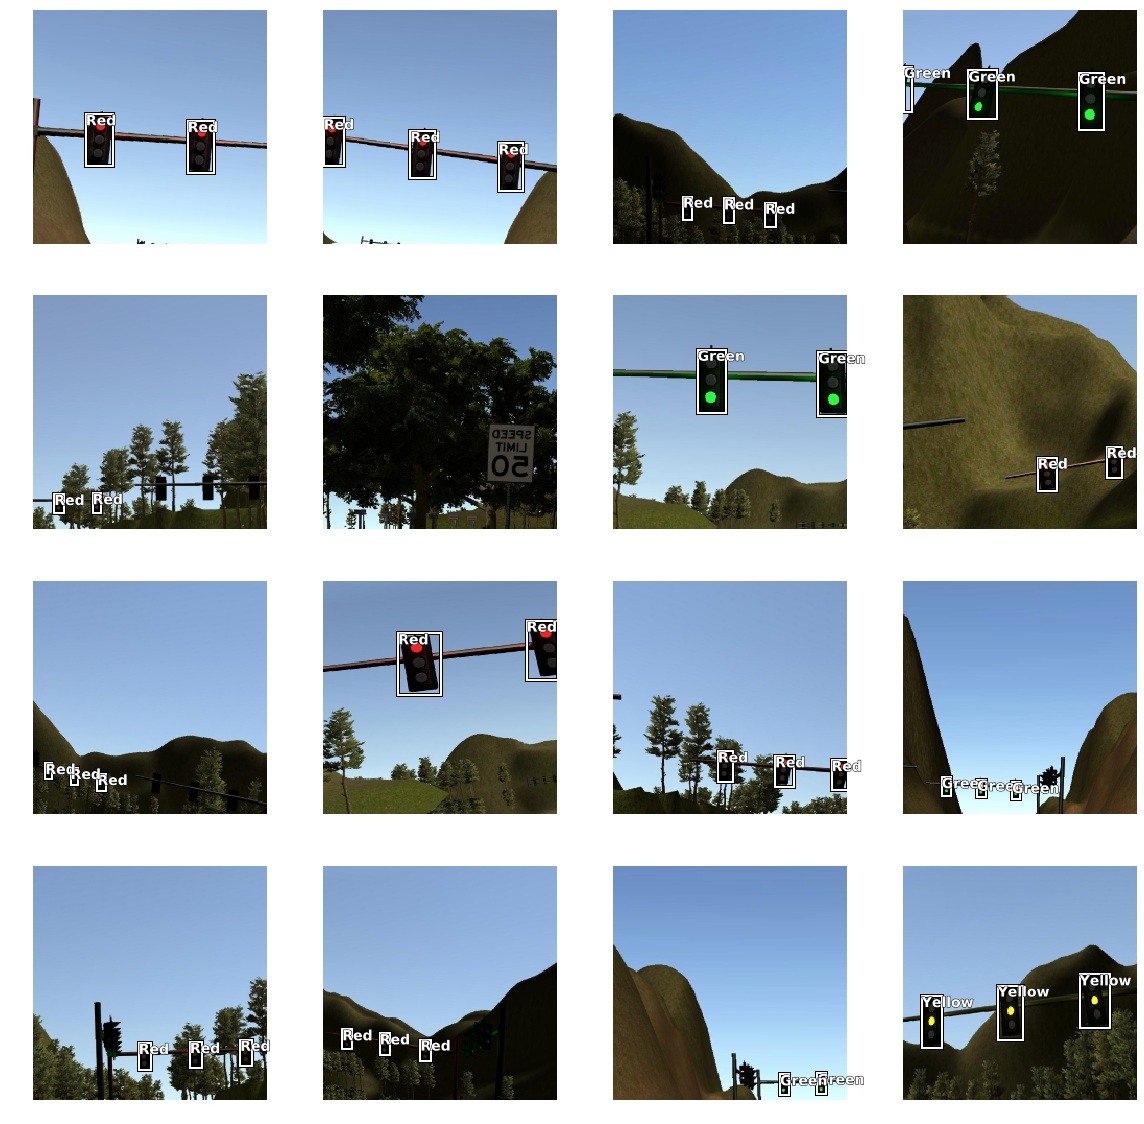

In [15]:
%%time
data.show_batch()

# Training

In [16]:
data.c

4

In [17]:
data

ImageDataBunch;

Train: LabelList (733 items)
x: SSDObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SSDObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: sim_data/JPEGImages;

Valid: LabelList (184 items)
x: SSDObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SSDObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: sim_data/JPEGImages;

Test: None

In [18]:
max_lr = 1e-3
lrs = np.array([max_lr/100, max_lr/10, max_lr])

In [19]:
ssd_model = SingleShotDetector(data, focal_loss=True, pretrained_path='sim-FL-1200')

/home/m090009/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/vision/learner.py:93: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [21]:
# ssd_model.learn.show_results(type=DatasetType.Test, ssd=ssd_model)
# ssd_model.learn.get_preds()

Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere


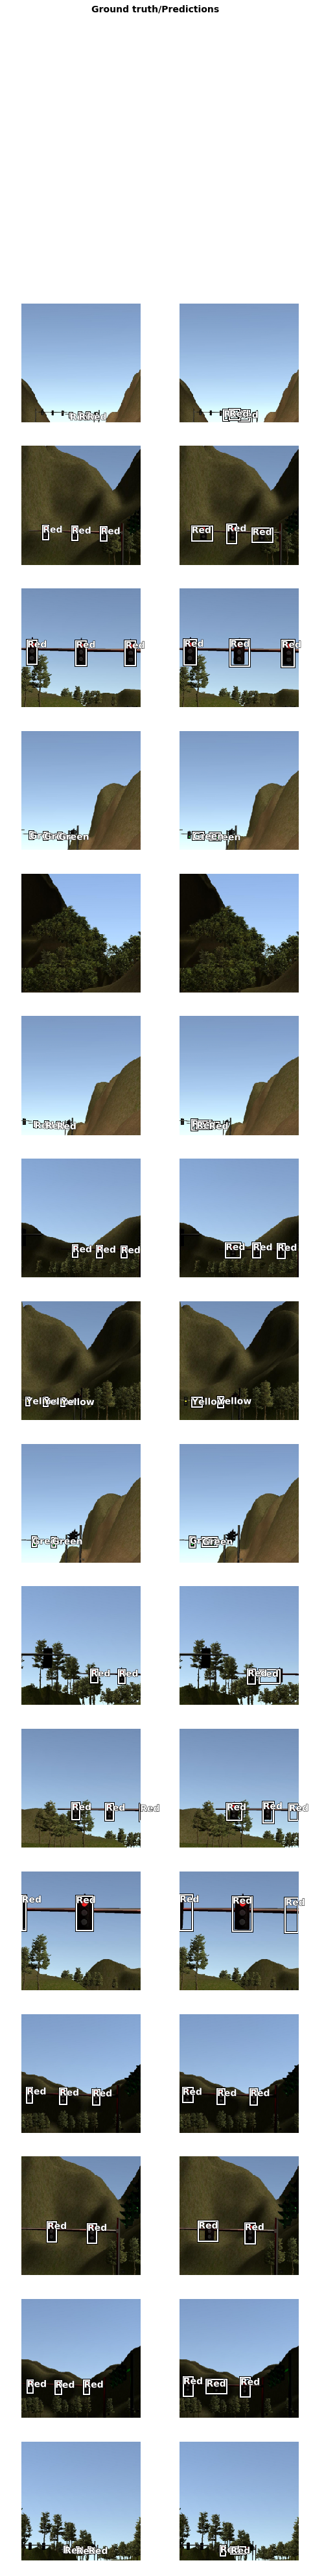

In [21]:
ssd_model.show_results(rows=20, thresh=0.28)

## Export

In [22]:
# %debug
EPOCHS = 100

In [23]:
ssd_model.fit(EPOCHS, lr=lrs)

/home/m090009/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Gradient overflow, skipping update
Gradient overflow, skipping update


## Save the Model

In [24]:
ssd_model.save('sim-FL-1300')

## Stage 2

In [25]:
ssd_model.learn.freeze_to(-1)
lrs = np.array([max_lr/100, max_lr/10, max_lr])
ssd_model.fit(EPOCHS, lrs/2)

Gradient overflow, skipping update


In [26]:
ssd_model.save('sim-FL-1400')

## Stage 3

In [27]:
ssd_model.learn.freeze_to(-2)
ssd_model.learn.fit(EPOCHS, lrs/2)

Gradient overflow, skipping update
Gradient overflow, skipping update


In [28]:
ssd_model.save('sim-FL-1500')

## Stage 4

In [29]:
ssd_model.learn.freeze_to(0)
ssd_model.learn.fit(EPOCHS, lrs/4)

Gradient overflow, skipping update
Gradient overflow, skipping update
Gradient overflow, skipping update


In [30]:
ssd_model.save('sim-FL-1600')

## Stage 5

In [31]:
ssd_model.learn.freeze_to(0)
ssd_model.learn.fit(EPOCHS, lrs/5)

Gradient overflow, skipping update


In [32]:
ssd_model.save('sim-FL-1700')

## Stage 6

In [33]:
ssd_model.learn.freeze_to(0)
ssd_model.learn.fit(EPOCHS, lrs/5)

Gradient overflow, skipping update
Gradient overflow, skipping update


In [34]:
ssd_model.save('sim-FL-1800')

Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere


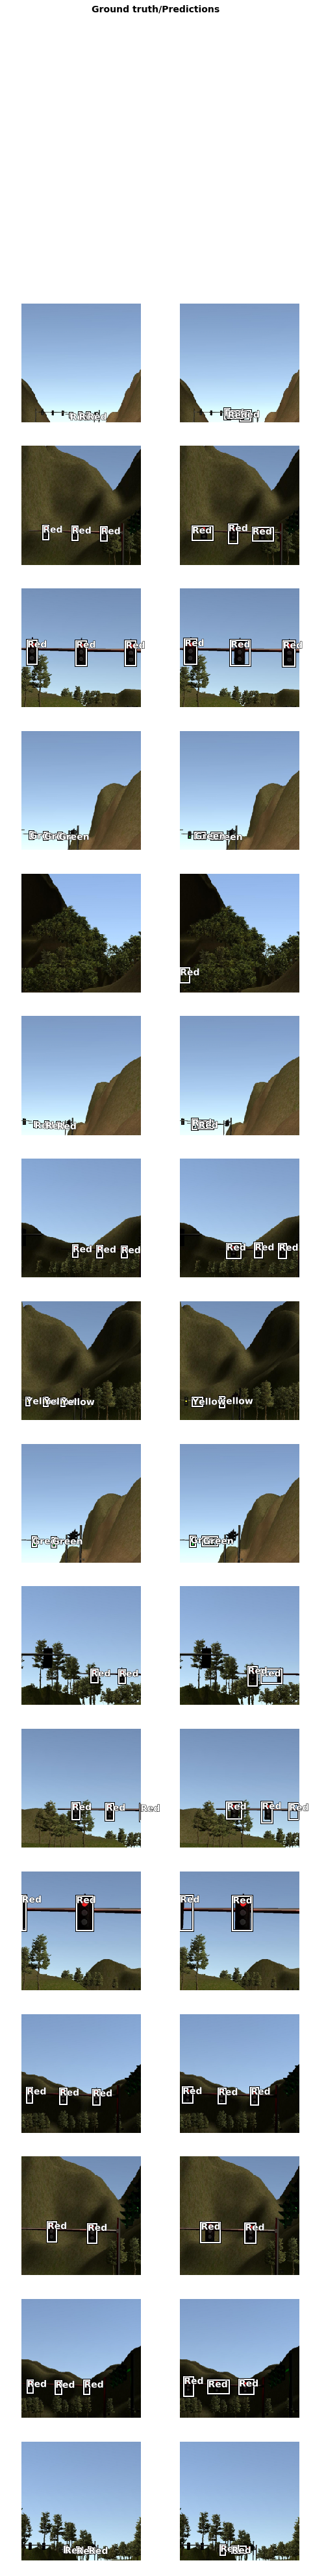

In [35]:
ssd_model.show_results(rows=20, thresh=0.28)

Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere


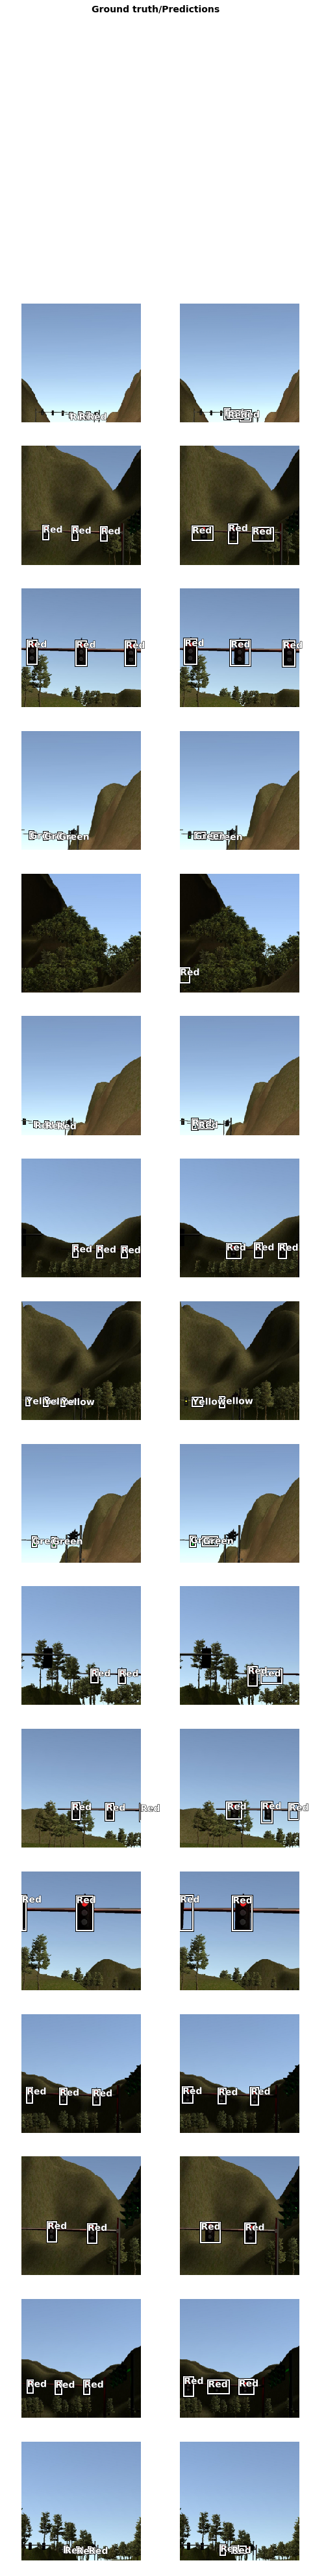

In [36]:
ssd_model.show_results(rows=20, thresh=0.3)

Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere


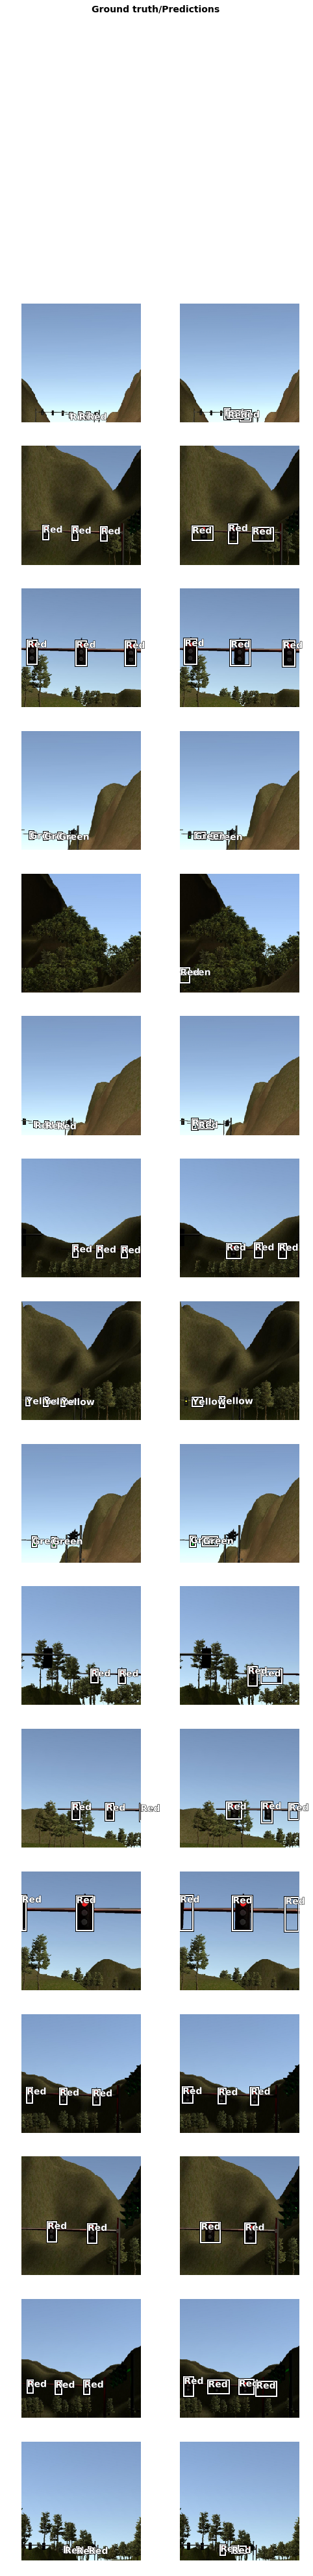

In [37]:
ssd_model.show_results(rows=20, thresh=0.1)

Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere


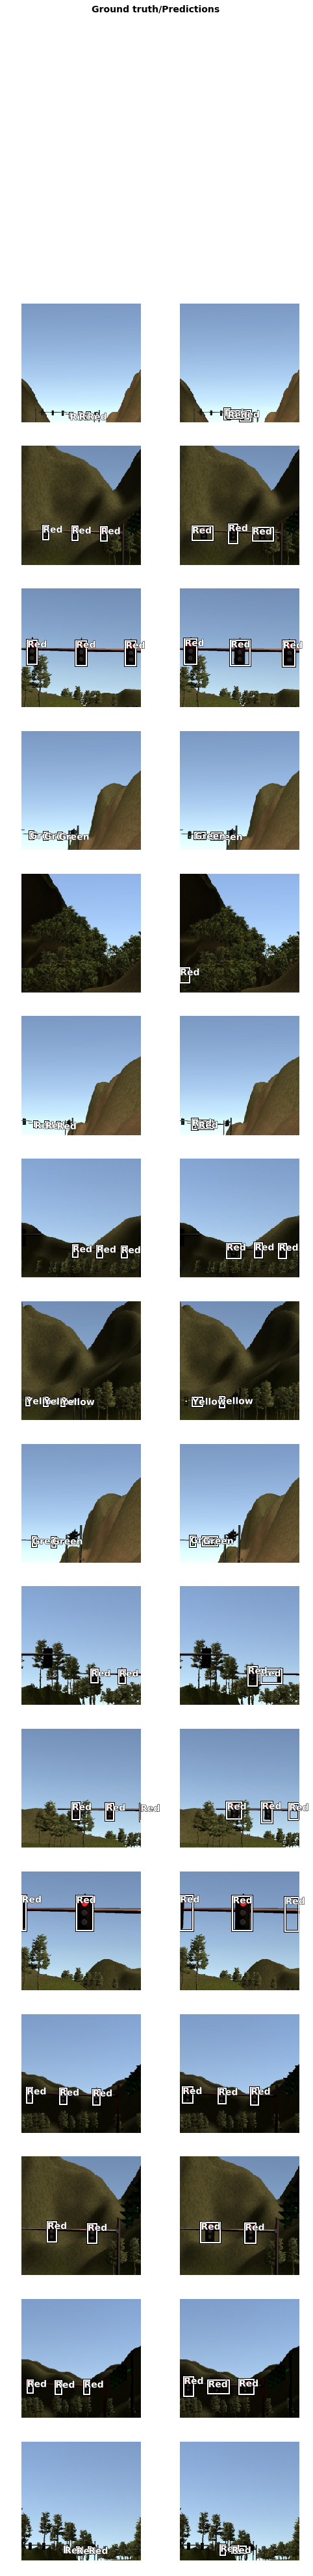

In [38]:
ssd_model.show_results(rows=20, thresh=0.2)

Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere
Heeeey, Im heeerere


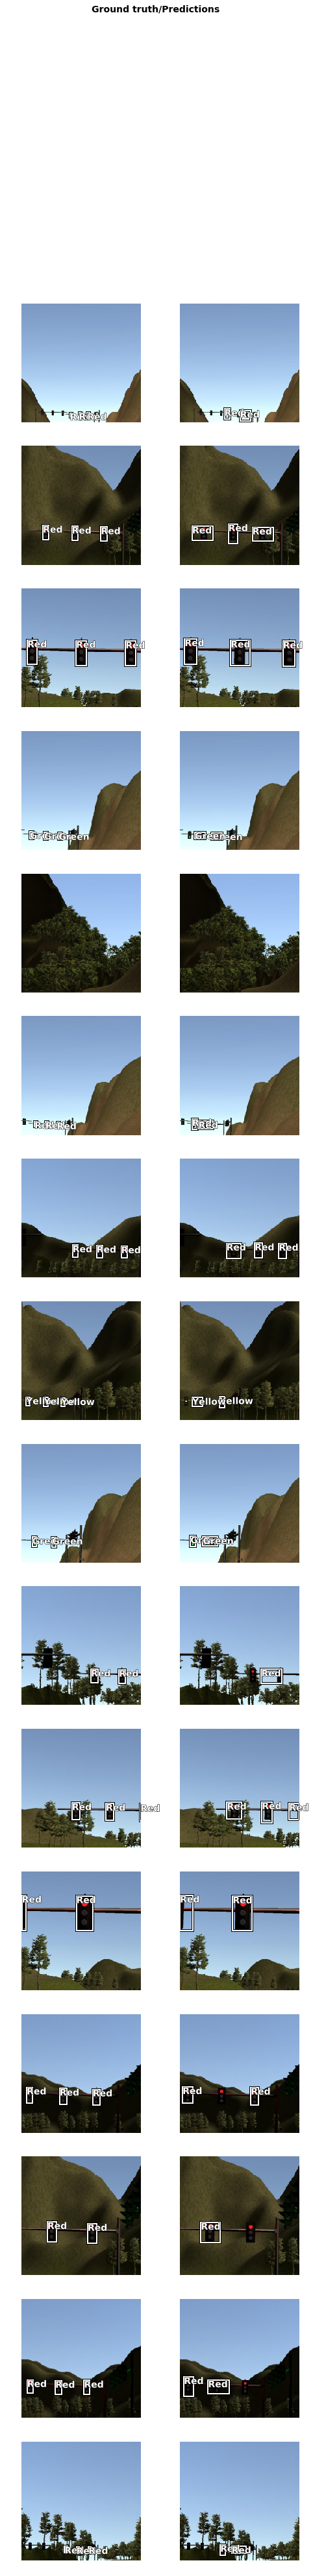

In [39]:
ssd_model.show_results(rows=20, thresh=0.4)

# Test on Udacity data

In [69]:
import os
from os.path import isfile
TESTPATH = Path('./sim_data/TESTJPEGSImages/')


## Get Test Images

In [70]:
def get_images(images_path):
    images = []
    for img in os.listdir(str(images_path)):
        if isfile(images_path/img):
            images.append(open_image(images_path/img))
    return images

test_images = get_images(TESTPATH)

## Predict

In [72]:
# test_prediction = ssd_model.learn.predict((test_images[0], None))
#Preprocessing 
data = (SSDObjectItemList.from_folder(IMG_PATH)
        .split_by_files(val_images)
        .label_from_func(get_y_func)
        .transform(get_transforms(), tfm_y=True, size=224)
        .databunch(bs=BS, collate_fn=bb_pad_collate)
        .normalize(imagenet_stats))
test_predictions = ssd_model.learn.model(test_images[0])

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not Image

In [21]:
%debug

> /home/m090009/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/vision/data.py(359)reconstruct()
    357 
    358     def reconstruct(self, t, x):
--> 359         (bboxes, labels) = t
    360         if len((labels - self.pad_idx).nonzero()) == 0: return
    361         i = (labels - self.pad_idx).nonzero().min()

ipdb> p t
tensor([[[  0.0107,  -5.9766,  -6.5078,  ...,  -7.6797,  -6.2734,  -5.4922],
         [ -0.0892,  -6.5859,  -6.9453,  ...,  -7.8711,  -6.4180,  -5.4648],
         [ -0.0818,  -6.1641,  -6.6523,  ...,  -7.7109,  -6.0273,  -5.3867],
         ...,
         [ -0.1519, -10.3125, -10.2266,  ..., -10.2734, -10.0781, -10.2266],
         [  0.0258, -10.1328, -10.3125,  ..., -10.2734, -10.1953, -10.3125],
         [  0.2554, -10.2031, -10.3516,  ..., -10.1797, -10.0859, -10.2969]]])
ipdb> q


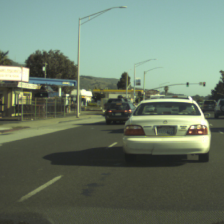

In [58]:
data.train_ds[0][0]

In [60]:
test_prediction = ssd_model.learn.predict(data.train_ds[0][0])

AttributeError: 'Learner' object has no attribute 'predict_array'

In [22]:
ssd_model.save('ssd-pascal-FL-20')

In [83]:
trn_tfms, val_tfms = tfms_from_model(resnet34, 224)
im = val_tfms(Image.open(PATH/'train/test1.jpg'))
ssd_model.learn.precompute = False
preds = ssd_model_array(im[None])
# np.argmax(preds)

NameError: name 'tfms_from_model' is not defined

## Show some results 

# Improve the result using feature pyramid